VectorAdam for Rotation Equivariant Geometry Optimization
======================================

This is an example on how to use VectorAdam for Laplacian smoothing in 2D.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import math
from util import *
from vectoradam import *
import matplotlib.pyplot as plt
from skimage import measure
from skimage.draw import disk
import imageio
import scipy


/var/folders/7x/kskkjxy57jd61clrqy9ndysc0000gp/T/ipykernel_39842/980443052.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread('hand.png')


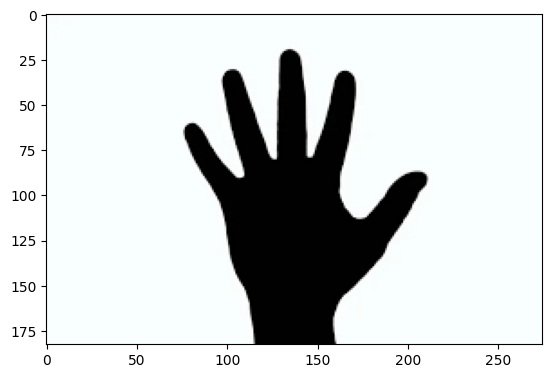

/var/folders/7x/kskkjxy57jd61clrqy9ndysc0000gp/T/ipykernel_39842/980443052.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imageio.imread('hand3.png')


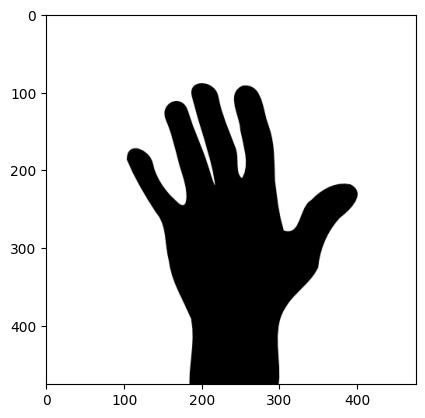

In [36]:
img1 = imageio.imread('hand.png')
plt.imshow(img1)
plt.show()
img2 = imageio.imread('hand3.png')
plt.imshow(img2)
plt.show()

/var/folders/7x/kskkjxy57jd61clrqy9ndysc0000gp/T/ipykernel_39842/2685789830.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  binary_image = imageio.imread(file)


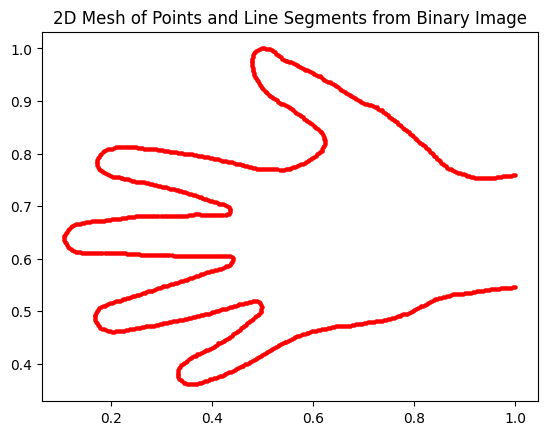

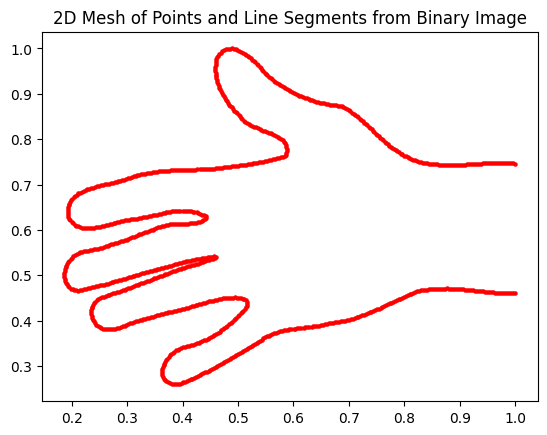

In [2]:
def image_to_mesh(file, num_points=10000):

    binary_image = imageio.imread(file)
    binary_image = binary_image.sum(-1) / binary_image.sum(-1).max()
    # Find contours in the binary image
    contours = measure.find_contours(binary_image, level=0.5)

    # Prepare points and line segments
    points = []
    line_segments = []

    contours = measure.find_contours(binary_image, level=0.5)
    
    points = []
    line_segments = []

    for contour in contours:
        # Calculate cumulative distance along the contour
        distances = np.sqrt(np.sum(np.diff(contour, axis=0)**2, axis=1))
        cumulative_distances = np.insert(np.cumsum(distances), 0, 0)
        
        # Interpolate to get the specified number of points
        desired_distances = np.linspace(0, cumulative_distances[-1], num_points)
        interpolated_points = np.array([
            np.interp(desired_distances, cumulative_distances, contour[:, dim])
            for dim in range(contour.shape[1])
        ]).T
        
        # Add interpolated points to the main list
        points.extend(interpolated_points)
    
        
        # Create line segments between consecutive points
        for i in range(len(points) - 1):
            line_segments.append((i, i + 1))
        
        # Connect the last point to the first to close the loop
        line_segments.append((i+1, 0))
    
    points = points / np.array(points).max(0)
    
    return points, line_segments

v1, l1 = image_to_mesh('hand.png')
v2, l2 = image_to_mesh('hand3.png')

fig = plt.figure()
# for segment in l1:
#     x_values = [segment[0][1], segment[1][1]]
#     y_values = [segment[0][0], segment[1][0]]
    # plt.plot(x_values, y_values, 'b')
plt.scatter(*zip(*v1), color='red', s=5)
plt.title("2D Mesh of Points and Line Segments from Binary Image")
plt.show()

fig = plt.figure()
# for segment in l2:
#     x_values = [segment[0][1], segment[1][1]]
#     y_values = [segment[0][0], segment[1][0]]
    # plt.plot(x_values, y_values, 'b')
plt.scatter(*zip(*v2), color='red', s=5)
plt.title("2D Mesh of Points and Line Segments from Binary Image")
plt.show()
# Points and line_segments contain the 2D mesh information


(20, 2)
(1000, 2) (1000, 2)


/var/folders/7x/kskkjxy57jd61clrqy9ndysc0000gp/T/ipykernel_39842/2685789830.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  binary_image = imageio.imread(file)


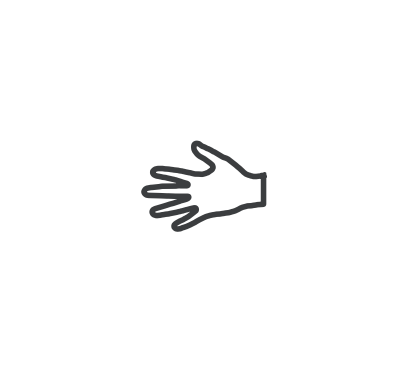

In [3]:
n = 12
vv1, ll2 = create_circle()
print(ll2.shape)
v1, l1 = image_to_mesh('hand.png')
v2, l2 = image_to_mesh('hand3.png')
v1 = np.array(v1)
l1 = np.array(l1)
v2 = np.array(v2)
l2 = np.array(l2)
print(v1.shape, l1.shape)
eps = 1
x_lim = [np.min(v1[:,0]) - eps, np.max(v1[:,0]) + eps]
y_lim = [np.min(v1[:,1]) - eps, np.max(v1[:,1]) + eps]

# keep track of meshes for later plotting
data= {}
data['original mesh'] = (v1, l1)

# plot the original mesh 
plot_mesh2d(v1,l1,x_lim=x_lim, y_lim=y_lim, showfig=True)

[0.10733404 0.36053928]
[1. 1.]


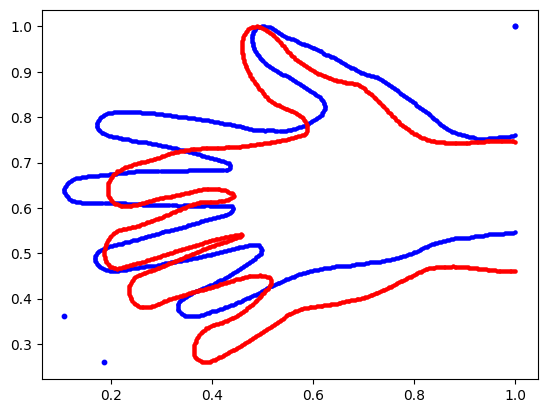

[0.91105461 1.15873116]


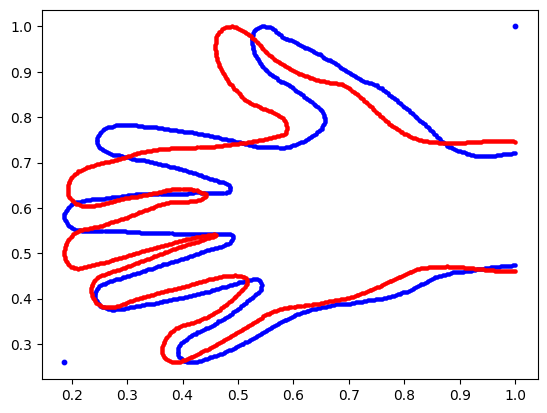

In [18]:
# naive rescale: 

print(v1.min(axis=0))
print(v1.max(axis=0))
plt.scatter(v1[:, 0], v1[:, 1], color='blue', s=5)
plt.scatter(v1.min(axis=0)[0], v1.min(axis=0)[1], color='blue', s=10)
plt.scatter(v1.max(axis=0)[0], v1.max(axis=0)[1], color='blue', s=10)
plt.scatter(v2[:, 0], v2[:, 1], color='red', s=5)
plt.scatter(v2.min(axis=0)[0], v2.min(axis=0)[1], color='blue', s=10)
plt.scatter(v2.max(axis=0)[0], v2.max(axis=0)[1], color='blue', s=10)
plt.show()



# rescale source to target:
s = (v2.max(0) - v2.min(0)) / (v1.max(0) - v1.min(0))
v1_n = s * ( v1 - v1.min(0) ) + v2.min(0)
print(s)
plt.scatter(v1_n[:, 0], v1_n[:, 1], color='blue', s=5)
plt.scatter(v2[:, 0], v2[:, 1], color='red', s=5)
plt.scatter(v2.min(axis=0)[0], v2.min(axis=0)[1], color='blue', s=10)
plt.scatter(v2.max(axis=0)[0], v2.max(axis=0)[1], color='blue', s=10)
plt.show()

In [29]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla

def biharmonic_weights(vertices, segments):
    """
    Compute biharmonic weights based on the mesh connectivity.
    """
    num_vertices = len(vertices)
    
    # Construct the Laplacian matrix based on the line segments
    L = sp.lil_matrix((num_vertices, num_vertices))
    for seg in segments:
        i, j = seg
        L[i, i] += 1
        L[j, j] += 1
        L[i, j] -= 1
        L[j, i] -= 1

    # Biharmonic weights: we solve for L.T * L to smooth out the deformation
    A = L.T @ L
    return A

def deform_shape(source_vertices, target_vertices, segments, alpha=0.1):
    """
    Deform the source shape to match the target shape using biharmonic weights.
    
    Parameters:
    - source_vertices: Nx2 array of (x, y) coordinates of the source shape.
    - target_vertices: Nx2 array of (x, y) coordinates of the target shape.
    - segments: List of pairs of indices defining the edges between vertices.
    - alpha: Regularization parameter for the biharmonic weights.
    
    Returns:
    - deformed_vertices: Nx2 array of the deformed vertices.
    """
    num_vertices = source_vertices.shape[0]

    # Compute biharmonic weights
    A = biharmonic_weights(source_vertices, segments)

    # Set up system of equations for x and y coordinates separately
    I = sp.identity(num_vertices)
    system_matrix = A + alpha * I  # Regularized biharmonic system

    # Deform along the x and y directions independently
    bx = alpha * target_vertices[:, 0]
    by = alpha * target_vertices[:, 1]
    
    # Solve for new positions
    deformed_x = spla.spsolve(system_matrix, bx)
    deformed_y = spla.spsolve(system_matrix, by)
    
    # Stack the deformed coordinates
    deformed_vertices = np.vstack((deformed_x, deformed_y)).T
    return deformed_vertices



# Perform deformation


In [32]:
control_points_indices = np.linspace(0, v1.shape[0] - 1, num=10, dtype=int)
deformed_vertices = deform_shape(v1_n, v2, l1)
print(deformed_vertices.shape)
print(deformed_vertices.max(), deformed_vertices.min())


(1000, 2)
0.9995788331545798 0.18680729707413884


[0.10733404 0.36053928]
[1. 1.]


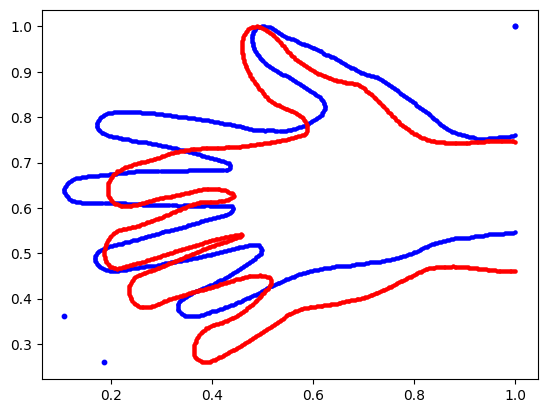

[0.91105461 1.15873116]


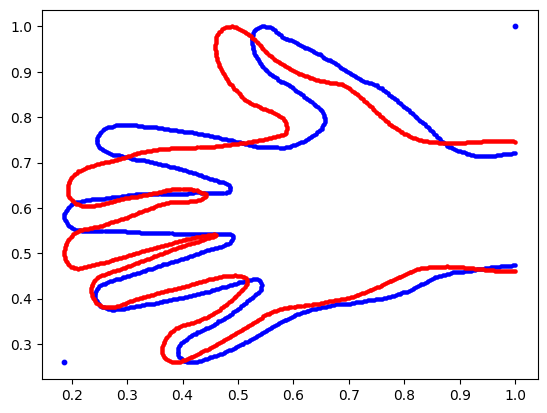

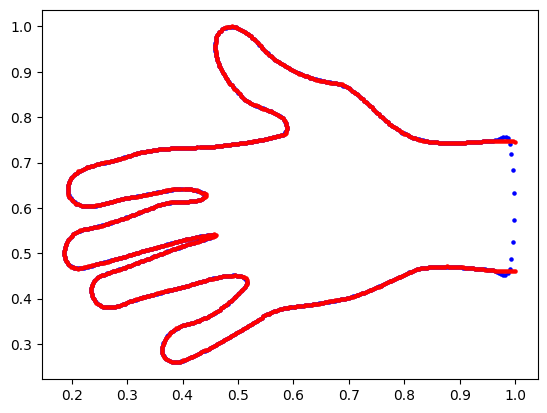

In [33]:

print(v1.min(axis=0))
print(v1.max(axis=0))
plt.scatter(v1[:, 0], v1[:, 1], color='blue', s=5)
plt.scatter(v1.min(axis=0)[0], v1.min(axis=0)[1], color='blue', s=10)
plt.scatter(v1.max(axis=0)[0], v1.max(axis=0)[1], color='blue', s=10)
plt.scatter(v2[:, 0], v2[:, 1], color='red', s=5)
plt.scatter(v2.min(axis=0)[0], v2.min(axis=0)[1], color='blue', s=10)
plt.scatter(v2.max(axis=0)[0], v2.max(axis=0)[1], color='blue', s=10)
plt.show()



# rescale source to target:
s = (v2.max(0) - v2.min(0)) / (v1.max(0) - v1.min(0))
v1_n = s * ( v1 - v1.min(0) ) + v2.min(0)
print(s)
plt.scatter(v1_n[:, 0], v1_n[:, 1], color='blue', s=5)
plt.scatter(v2[:, 0], v2[:, 1], color='red', s=5)
plt.scatter(v2.min(axis=0)[0], v2.min(axis=0)[1], color='blue', s=10)
plt.scatter(v2.max(axis=0)[0], v2.max(axis=0)[1], color='blue', s=10)
plt.show()

plt.scatter(deformed_vertices[:, 0], deformed_vertices[:, 1], color='blue', s=5)
plt.scatter(v2[:, 0], v2[:, 1], color='red', s=5)
plt.show()